In [1]:
import nibabel                      as nib
import nibabel.freesurfer.mghformat as mgh
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(0)
np.random.seed(0)

In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.5.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [3]:
from scipy import ndimage

def read_mgz_file(filepath):
    """Read and load volume"""
    # Read file
    scan = mgh.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def convertersize(volume):
    """convertersize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 256
    desired_width = 256
    desired_height = 256
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 270, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def crop_image(img):
    # Find first and last slices that contain parts of the brain
    blank = img[0].sum()
    x = []
    for i in range(len(img)):
        if img[i,:,:].sum() != blank:
            x.append(i)
    y = []
    for i in range(len(img)):
        if img[:,i,:].sum() != blank:
            y.append(i)
    z = []
    for i in range(len(img)):
        if img[:,:,i].sum() != blank:
            z.append(i)
    # Use these to crop the 3D images
    img = np.squeeze(img[min(x):max(x), min(y):max(y), min(z):max(z)])
    
    # Set the desired depth
    desired_depth = 96
    desired_width = 96
    desired_height = 96
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_mgz_file(path)
    #  convertersize
    volume = convertersize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    # Crop 3D image
    volume = crop_image(volume)
    return volume

In [4]:
scan = process_scan('Scans_CN/OAS30005_MR_d0143.mgz')

Dimension of the CT scan is: (96, 96, 96)


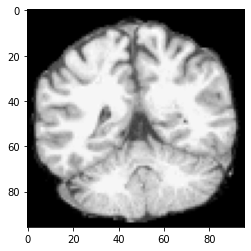

In [5]:
image = scan
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 32]), cmap="gray")
plt.show()

Dimension of the CT scan is: (96, 96, 96)


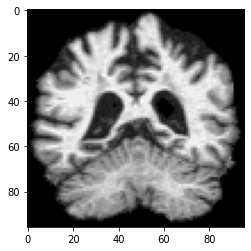

In [6]:
scan = process_scan('Scans_Converters/OAS30022_MR_d1324.mgz')
image = scan
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 32]), cmap="gray")
plt.show()

Dimension of the CT scan is: (96, 96, 96)


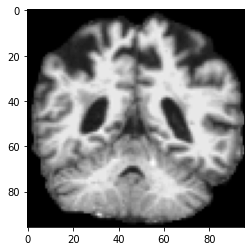

In [7]:
scan = process_scan('Scans_Converters/OAS30041_MR_d6548.mgz')
image = scan
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 32]), cmap="gray")
plt.show()

## Reading data

In [8]:
# Folder "Scans_CN" consist of subjects who remained cognitively converters for the whole study.
CN_scan_paths = [
    os.path.join(os.getcwd(), "Scans_CN", x)
    for x in os.listdir("Scans_CN")
]
# Folder "Scans_Converters" consist of subjects who converted from CN to MCI > 0.
converters_scan_paths = [
    os.path.join(os.getcwd(), "Scans_Converters", x)
    for x in os.listdir("Scans_Converters")
]

print("MRI scans for patients remaining CN: " + str(len(CN_scan_paths)))
print("MRI scans for patients converting to AD: " + str(len(converters_scan_paths)))

MRI scans for patients remaining CN: 154
MRI scans for patients converting to AD: 50


In [9]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
CN_scans = np.array([process_scan(path) for path in CN_scan_paths])
converters_scans = np.array([process_scan(path) for path in converters_scan_paths])

# For the converters assign 1, for the CN subjects assign 0.
CN_labels = np.array([0 for _ in range(len(CN_scans))])
converters_labels = np.array([1 for _ in range(len(converters_scans))])


# Randomly select samples from CN to create even 50/50 split
select = np.random.choice(len(CN_scans),len(converters_scans), replace=False)
CN_scans = CN_scans[select]
CN_labels = CN_labels[select]

In [10]:
# Create another random split for selection
select = np.random.choice(len(CN_scans),len(converters_scans), replace=False)
# Split data in the ratio 80-20 for training and validation.
x_train = np.concatenate((CN_scans[select[:35]], converters_scans[select[:35]]), axis=0)
y_train = np.concatenate((CN_labels[select[:35]], converters_labels[select[:35]]), axis=0)
x_val = np.concatenate((CN_scans[select[35:]], converters_scans[select[35:]]), axis=0)
y_val = np.concatenate((CN_labels[select[35:]], converters_labels[select[35:]]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0]))

Number of samples in train and validation are 70 and 30.


In [11]:
x_train_rgb = np.repeat(x_train[..., np.newaxis], 3, -1)
x_val_rgb = np.repeat(x_val[..., np.newaxis], 3, -1)

In [12]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train_rgb, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val_rgb, y_val))

In [13]:
batch_size = 1
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train_rgb))
    .batch(batch_size)
    .prefetch(1)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val_rgb))
    .batch(batch_size)
    .prefetch(1)
)

In [14]:
# for tensorflow.keras
from classification_models_3D.tfkeras import Classifiers

MobileNetV2, preprocess_input = Classifiers.get('mobilenetv2')
base_model = MobileNetV2(input_shape=(96, 96, 96, 3), weights='imagenet')
# model = VGG19(input_shape=(64, 64, 64, 3), weights='imagenet')

x = base_model.output
x = tf.keras.layers.Dense(1000,activation='relu')(x)
x = tf.keras.layers.Dense(500,activation='relu')(x) 
x = tf.keras.layers.Dense(1, activation= 'sigmoid')(x)
model = keras.Model(inputs = base_model.input, outputs = x)

In [15]:
# base_model.summary()
# model.summary()

In [16]:
auc = tf.keras.metrics.AUC()  # instantiate it here to have a shorter handle

# Compile model.
initial_learning_rate = 0.01
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc", auc],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=30)

# Train the model, doing validation at the end of each epoch
epochs = 200
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/200
70/70 - 669s - loss: 0.7103 - acc: 0.3714 - auc: 0.3298 - val_loss: 0.6932 - val_acc: 0.5000 - val_auc: 0.5000


C:\Users\Justin\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/200
70/70 - 210s - loss: 0.6962 - acc: 0.5000 - auc: 0.4229 - val_loss: 0.6935 - val_acc: 0.5000 - val_auc: 0.5000
Epoch 3/200
70/70 - 207s - loss: 0.6968 - acc: 0.3714 - auc: 0.3073 - val_loss: 0.6932 - val_acc: 0.5000 - val_auc: 0.5000
Epoch 4/200
70/70 - 211s - loss: 0.6947 - acc: 0.3571 - auc: 0.3616 - val_loss: 0.6931 - val_acc: 0.5000 - val_auc: 0.5000
Epoch 5/200
70/70 - 208s - loss: 0.6944 - acc: 0.4429 - auc: 0.4143 - val_loss: 0.6932 - val_acc: 0.5000 - val_auc: 0.5000
Epoch 6/200
70/70 - 211s - loss: 0.6972 - acc: 0.3857 - auc: 0.2616 - val_loss: 0.6932 - val_acc: 0.5000 - val_auc: 0.5000
Epoch 7/200
70/70 - 209s - loss: 0.6945 - acc: 0.4429 - auc: 0.4114 - val_loss: 0.6932 - val_acc: 0.5000 - val_auc: 0.5000
Epoch 8/200
70/70 - 208s - loss: 0.6953 - acc: 0.3714 - auc: 0.3649 - val_loss: 0.6931 - val_acc: 0.5000 - val_auc: 0.5000
Epoch 9/200
70/70 - 206s - loss: 0.6963 - acc: 0.5000 - auc: 0.3943 - val_loss: 0.6932 - val_acc: 0.5000 - val_auc: 0.5000
Epoch 10/200
70/

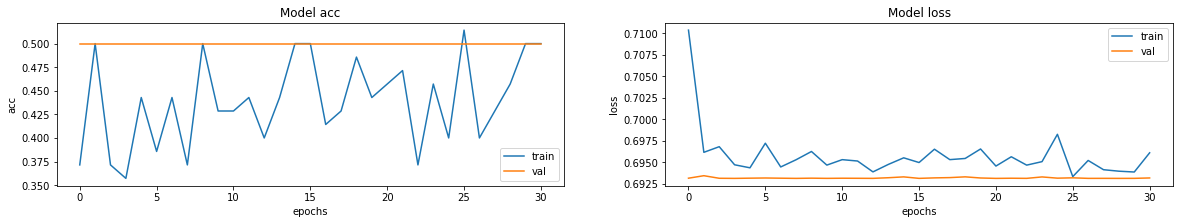

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [18]:
# Load best weights.
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val_rgb[19], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )
print(y_val[19])

This model is 50.02 percent confident that CT scan is normal
This model is 49.98 percent confident that CT scan is abnormal
1


In [19]:
for i in range(30):
    # Load best weights.
    model.load_weights("3d_image_classification.h5")
    prediction = model.predict(np.expand_dims(x_val_rgb[i], axis=0))[0]
    scores = [1 - prediction[0], prediction[0]]

    class_names = ["normal", "abnormal"]
    for score, name in zip(scores, class_names):
        print(
            "This model is %.2f percent confident that CT scan is %s"
            % ((100 * score), name)
        )
    print(y_val[i])

This model is 50.02 percent confident that CT scan is normal
This model is 49.98 percent confident that CT scan is abnormal
0
This model is 50.02 percent confident that CT scan is normal
This model is 49.98 percent confident that CT scan is abnormal
0
This model is 50.02 percent confident that CT scan is normal
This model is 49.98 percent confident that CT scan is abnormal
0
This model is 50.02 percent confident that CT scan is normal
This model is 49.98 percent confident that CT scan is abnormal
0
This model is 50.02 percent confident that CT scan is normal
This model is 49.98 percent confident that CT scan is abnormal
0
This model is 50.02 percent confident that CT scan is normal
This model is 49.98 percent confident that CT scan is abnormal
0
This model is 50.02 percent confident that CT scan is normal
This model is 49.98 percent confident that CT scan is abnormal
0
This model is 50.02 percent confident that CT scan is normal
This model is 49.98 percent confident that CT scan is abn